# Colab Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Book Summary Condensing Project

## 0) Requirements & Imports

In [ ]:
!pip install invisible_watermark transformers accelerate safetensors diffusers textacy

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import nltk
import torch
from transformers import pipeline
from diffusers import DiffusionPipeline
import torch
from IPython.display import display, HTML
import base64
from io import BytesIO
from tqdm import tqdm
import diffusers
import os
from PIL import Image
import re
import json
from textacy.preprocessing import normalize, replace, remove
%matplotlib inline

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1) Data Extraction

In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/data/'
FILE_PATH = DATA_FOLDER + "booksummaries.txt"

In [ ]:
lines = []
with open(FILE_PATH, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        lines.append(line)

In [ ]:
print('Records count:', len(lines))

Records count: 16559


### Generating Regex

In [ ]:
regex = {
    'ID': r'(\d+)',
    'Unknown Characters': r'([a-z0-9_/]+)',
    'Title and Author': r'(.+)',
    'Publish Date': r'(\d[\d\-]*)',
    'Genres List': r'({\".*\"})',
    'Summary': r'(.+)',
    'Space': r'\s+',
    'Tab': r'\t+',
    'SL': r'^',
    'EL': r'$'
}

fields = ['ID', 'Unknown Characters', 'Title and Author', 'Publish Date', 'Genres List', 'Summary']

In [ ]:
possible_combinations = []

def generate_fields_combinations(fields, current_seq=[]):
  if not fields:
    possible_combinations.append(current_seq.copy())
    return
  generate_fields_combinations(fields[1:], current_seq)
  generate_fields_combinations(fields[1:], current_seq + [fields[0]])

generate_fields_combinations(fields[2:])
possible_combinations = ([[*fields[0:2], *comb] for comb in possible_combinations[::-1]])[:-1]

print("Possible combinations count:", len(possible_combinations))

Possible combinations count: 15


In [ ]:
regex_list = []

def seprator(key1, key2):
  if (key1, key2) in [
      ('Title and Author', 'Summary'),
      ('Title and Author', 'Publish Date'),
      ('Publish Date', 'Summary'),
    ]:
    return r'(\s*\t(\s|\t)*)'
  else:
    return r'(\s|\t)+'


for combination in possible_combinations:
  pattern = regex['SL'] + regex[combination[0]]
  prev_key = combination[0]
  for key in combination[1:]:
    pattern += seprator(prev_key, key) + regex[key]
    prev_key = key
  regex_list.append([pattern + regex['EL'], combination])

display(pd.DataFrame(regex_list, columns=['Regex', 'Combination']))

,Regex,Combination
0,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s*\t(...,"[ID, Unknown Characters, Title and Author, Pub..."
1,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s*\t(...,"[ID, Unknown Characters, Title and Author, Pub..."
2,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s*\t(...,"[ID, Unknown Characters, Title and Author, Pub..."
3,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s*\t(...,"[ID, Unknown Characters, Title and Author, Pub..."
4,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s|\t)...,"[ID, Unknown Characters, Title and Author, Gen..."
5,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s|\t)...,"[ID, Unknown Characters, Title and Author, Gen..."
6,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)(\s*\t(...,"[ID, Unknown Characters, Title and Author, Sum..."
7,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(.+)$,"[ID, Unknown Characters, Title and Author]"
8,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(\d[\d\-]*)...,"[ID, Unknown Characters, Publish Date, Genres ..."
9,^(\d+)(\s|\t)+([a-z0-9_/]+)(\s|\t)+(\d[\d\-]*)...,"[ID, Unknown Characters, Publish Date, Genres ..."


### Extracting Data

In [ ]:
with open(DATA_FOLDER + "extracted_data.csv", 'w', newline='', encoding="utf-8") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(fields)

  for line in lines:
    error = False
    for regex, field_names in regex_list:
      match = re.search(regex, line)
      if match:
        groups = [m for m in match.groups() if m != None and not m.isspace()]
        data_row = []

        if (len(fields) < len(groups)):
          error = True
          break

        error = True
        i, j = 0, 0
        while i < len(fields) and j < len(groups):
            if fields[i] == field_names[j]:
                data_row.append(groups[j])
                i += 1
                j += 1
            else:
                data_row.append(None)
                i += 1
        data_row.extend([None] * (len(fields) - i))

        writer.writerow(data_row)
        error = False
        break
    if error:
      print(f"Can't match: '{line}'")

In [ ]:
data = pd.read_csv(DATA_FOLDER + 'extracted_data.csv')
data.count()

ID                    16559
Unknown Characters    16559
Title and Author      16559
Publish Date          10949
Genres List           12841
Summary               16559
dtype: int64

## 2) Data Cleaning

### Removing Unecessary Data

In [ ]:
CSV_FILE = DATA_FOLDER + "extracted_data.csv"
data = pd.read_csv(CSV_FILE)
data.head()

,ID,Unknown Characters,Title and Author,Publish Date,Genres List,Summary
0,620,/m/0hhy,Animal Farm\tGeorge Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, cal..."
1,843,/m/0k36,A Clockwork Orange\tAnthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future England..."
2,986,/m/0ldx,The Plague\tAlbert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five pa...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding\tDav...,NaN,NaN,The argument of the Enquiry proceeds by a seri...
4,2080,/m/0wkt,A Fire Upon the Deep\tVernor Vinge\t,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky W...


In [ ]:
data = data.drop('Unknown Characters', axis=1)
data.head()

,ID,Title and Author,Publish Date,Genres List,Summary
0,620,Animal Farm\tGeorge Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, cal..."
1,843,A Clockwork Orange\tAnthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future England..."
2,986,The Plague\tAlbert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five pa...
3,1756,An Enquiry Concerning Human Understanding\tDav...,NaN,NaN,The argument of the Enquiry proceeds by a seri...
4,2080,A Fire Upon the Deep\tVernor Vinge\t,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky W...


In [ ]:
data['Title'] = data['Title and Author'].str.strip().str.split('\t', expand=True)[0]
data['Author'] = data['Title and Author'].str.strip().str.split('\t', expand=True)[1]
data = data.drop('Title and Author', axis=1)
data.head()

,ID,Publish Date,Genres List,Summary,Title,Author
0,620,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, cal...",Animal Farm,George Orwell
1,843,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future England...",A Clockwork Orange,Anthony Burgess
2,986,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five pa...,The Plague,Albert Camus
3,1756,NaN,NaN,The argument of the Enquiry proceeds by a seri...,An Enquiry Concerning Human Understanding,David Hume
4,2080,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky W...,A Fire Upon the Deep,Vernor Vinge


In [ ]:
def extract_genres(genre_list_json):
  try:
    if isinstance(genre_list_json, str):
      genres = json.loads(genre_list_json)
      return ", ".join(genres.values())
    else:
      return None
  except json.JSONDecodeError:
    return None

data['Genres'] = data['Genres List'].apply(extract_genres)
data.head()

,ID,Publish Date,Genres List,Summary,Title,Author,Genres
0,620,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, cal...",Animal Farm,George Orwell,"Roman à clef, Satire, Children's literature, S..."
1,843,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future England...",A Clockwork Orange,Anthony Burgess,"Science Fiction, Novella, Speculative fiction,..."
2,986,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five pa...,The Plague,Albert Camus,"Existentialism, Fiction, Absurdist fiction, Novel"
3,1756,NaN,NaN,The argument of the Enquiry proceeds by a seri...,An Enquiry Concerning Human Understanding,David Hume,None
4,2080,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky W...,A Fire Upon the Deep,Vernor Vinge,"Hard science fiction, Science Fiction, Specula..."


In [ ]:
data = data.drop('Genres List', axis=1)
fields = ["ID", "Title", "Author", "Publish Date", "Genres", "Summary"]
data = data[fields]

data.head()

,ID,Title,Author,Publish Date,Genres,Summary
0,620,Animal Farm,George Orwell,1945-08-17,"Roman à clef, Satire, Children's literature, S...","Old Major, the old boar on the Manor Farm, cal..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"Science Fiction, Novella, Speculative fiction,...","Alex, a teenager living in near-future England..."
2,986,The Plague,Albert Camus,1947,"Existentialism, Fiction, Absurdist fiction, Novel",The text of The Plague is divided into five pa...
3,1756,An Enquiry Concerning Human Understanding,David Hume,NaN,None,The argument of the Enquiry proceeds by a seri...
4,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"Hard science fiction, Science Fiction, Specula...",The novel posits that space around the Milky W...


### Unifying Null Values

In [ ]:
data = data.astype(str)
data['ID'] = data['ID'].astype(int)
data = data.replace(['nan', 'None'], pd.NA)

### Filtering Unrelated Data

#### Normalizing Summaries Text

In [ ]:
def refine_text(text):
  # text = text.to_string(index=False).strip()
  text = re.sub("\n", " ", text)
  text = normalize.bullet_points(text)
  text = normalize.unicode(text)
  # text = normalize.hyphenated_words(text)
  text = normalize.repeating_chars(text, chars=" ,.")
  text = replace.currency_symbols(text, repl=" ")
  text = replace.emails(text, repl=" ")
  text = replace.emojis(text, repl=" ")
  text = replace.hashtags(text, repl=" ")
  text = replace.phone_numbers(text, repl=" ")
  # text = replace.numbers(text, repl=" ")
  text = replace.urls(text, repl=" ")
  text = replace.user_handles(text, repl=" ")
  text = remove.accents(text)
  text = remove.html_tags(text)
  text = remove.punctuation(text, only=r'"\':;%©@*()-[]{}/#%†|=~_\\<>')
  text = normalize.quotation_marks(text)
  text = normalize.whitespace(text)
  return text

In [ ]:
data['Summary'] = data['Summary'].apply(refine_text)

In [ ]:
display(data.loc[data['Summary'].str.contains('^[a-zA-Z0-9]'), ['ID', 'Summary']])

,ID,Summary
0,620,"Old Major, the old boar on the Manor Farm, cal..."
1,843,"Alex, a teenager living in near future England..."
2,986,The text of The Plague is divided into five pa...
3,1756,The argument of the Enquiry proceeds by a seri...
4,2080,The novel posits that space around the Milky W...
...,...,...
16554,36934824,"Prue McKeel, having rescued her brother from t..."
16555,37054020,The reader first meets Rapp while he is doing ...
16556,37122323,The book follows very rough chronological orde...
16557,37132319,Colbert addresses topics including Wall Street...


#### Removing Unrelated Data

In [ ]:
threshold = 40
filtered_data = data[data['Summary'].str.len() <= threshold]
display(filtered_data)

,ID,Title,Author,Publish Date,Genres,Summary
2045,1078455,The Kennel Murder Case,S. S. Van Dine,<NA>,"Mystery, Fiction, Suspense",Plot outline description
3879,2664992,Slavers,Chris Pramas,2000,Role-playing game,Publication histor
4045,2832333,Deathstalker,Simon Green,<NA>,"Science Fiction, Speculative fiction",!
5271,4118477,Golem in the Gears,Piers Anthony,1986-02,"Science Fiction, Speculative fiction, Fantasy,...",pl Zakochany golem
5595,4507859,The Adventures of Super Diaper Baby,Dav Pilkey,2002,Children's literature,Plot summary
5693,4597024,The Deathlord of Ixia,John Grant,1992,"Gamebook, Speculative fiction, Children's lite...",Receptio
5879,4817875,The Caverns of Kalte,Joe Dever,1984,"Gamebook, Speculative fiction, Fantasy, Childr...",Receptio
5972,4908574,The Eyes of Darkness,Dean Koontz,1981,"Speculative fiction, Horror, Fiction, Romance ...",Character
6335,5264015,Created By,Richard Christian Matheson,1993,"Speculative fiction, Horror, Fiction",Plot outline description
6622,5466643,The Saint in Pursuit,Leslie Charteris,1970,Mystery,To be added.


In [ ]:
data.loc[filtered_data.index, 'Summary'] = None

filtered_data = data[data['Summary'].str.len() <= threshold]
display(filtered_data.empty)

True

In [ ]:
def count_duplicated_values():
  for column in data.columns:
    non_null_values = data[column].dropna()
    duplicated_count = non_null_values.duplicated().sum()
    print(f"Column '{column}' has {duplicated_count} duplicated values.")

In [ ]:
count_duplicated_values()

Column 'ID' has 0 duplicated values.
Column 'Title' has 282 duplicated values.
Column 'Author' has 9463 duplicated values.
Column 'Publish Date' has 8310 duplicated values.
Column 'Genres' has 10687 duplicated values.
Column 'Summary' has 1 duplicated values.


In [ ]:
for column in data.columns:
    non_null_values = data[column].dropna()
    duplicated_values = non_null_values[non_null_values.duplicated(keep=False)]
    if not duplicated_values.empty:
        print(f"Duplicated values in column '{column}':")
        duplicates_with_ids = data[data[column].isin(duplicated_values)][['ID', column]]
        duplicates_with_ids = duplicates_with_ids.reset_index(drop=True)
        display(duplicates_with_ids)

Duplicated values in column 'Title':


,ID,Title
0,9662,Exodus
1,12667,Genesis
2,29798,The Lord of the Rings
3,31434,The Sentinel
4,45896,The Stranger
...,...,...
523,33770305,Restoration
524,33770810,Conqueror
525,33861076,Brothers in Arms
526,33915255,Ceremony


Duplicated values in column 'Author':


,ID,Author
0,620,George Orwell
1,843,Anthony Burgess
2,986,Albert Camus
3,1756,David Hume
4,2080,Vernor Vinge
...,...,...
11411,36372465,Timothy Zahn
11412,36551772,Michael Chabon
11413,36934824,Colin Meloy
11414,37054020,Vince Flynn


Duplicated values in column 'Publish Date':


,ID,Publish Date
0,843,1962
1,986,1947
2,2890,1968
3,4081,1996-10-01
4,4082,1995-10-01
...,...,...
9338,36534061,1997
9339,37054020,2000-06-01
9340,37122323,2010-11-16
9341,37132319,2012-10-02


Duplicated values in column 'Genres':


,ID,Genres
0,2080,"Hard science fiction, Science Fiction, Specula..."
1,4081,"Science Fiction, Speculative fiction"
2,4082,"Science Fiction, Speculative fiction"
3,4386,Religious text
4,6020,"Speculative fiction, Fiction, Novel"
...,...,...
11429,36126792,"Gothic fiction, Young adult literature"
11430,36372465,Science Fiction
11431,36534061,"Thriller, Fiction, Suspense"
11432,37054020,"Thriller, Fiction"


Duplicated values in column 'Summary':


,ID,Summary
0,7175594,As described by Sherryl Connelly of the New Yo...
1,12816144,As described by Sherryl Connelly of the New Yo...


In [ ]:
data.loc[data['Summary'].duplicated(keep=False), 'Summary'] = None
count_duplicated_values()

Column 'ID' has 0 duplicated values.
Column 'Title' has 282 duplicated values.
Column 'Author' has 9463 duplicated values.
Column 'Publish Date' has 8310 duplicated values.
Column 'Genres' has 10687 duplicated values.
Column 'Summary' has 0 duplicated values.


### Testing Edge Cases

In [ ]:
edge_cases = [3527550, 84449]
data[data['ID'].isin(edge_cases)]

,ID,Title,Author,Publish Date,Genres,Summary
348,84449,The Closing of the American Mind,Allan Bloom,1987,<NA>,class toccolours style float right margin left...
4735,3527550,Master Mike and the Miracle Maid,<NA>,<NA>,<NA>,"17 year old Mike, a comic book fan who collect..."


### Saving Dataset

In [ ]:
data.to_csv(DATA_FOLDER + "cleaned_data.csv", index=False)

## 3) Data Visualizing

In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/data/'
CSV_FILE = DATA_FOLDER + "cleaned_data.csv"
data = pd.read_csv(CSV_FILE)

### Visualize missing data

In [ ]:
def visualize_missing_data(data):
    plt.figure(figsize=(12, 7))
    plt.title("Missing Data Heatmap", size=16)
    sns.heatmap(data.isna(), yticklabels=False, cbar=False, cmap='viridis')
    plt.show()

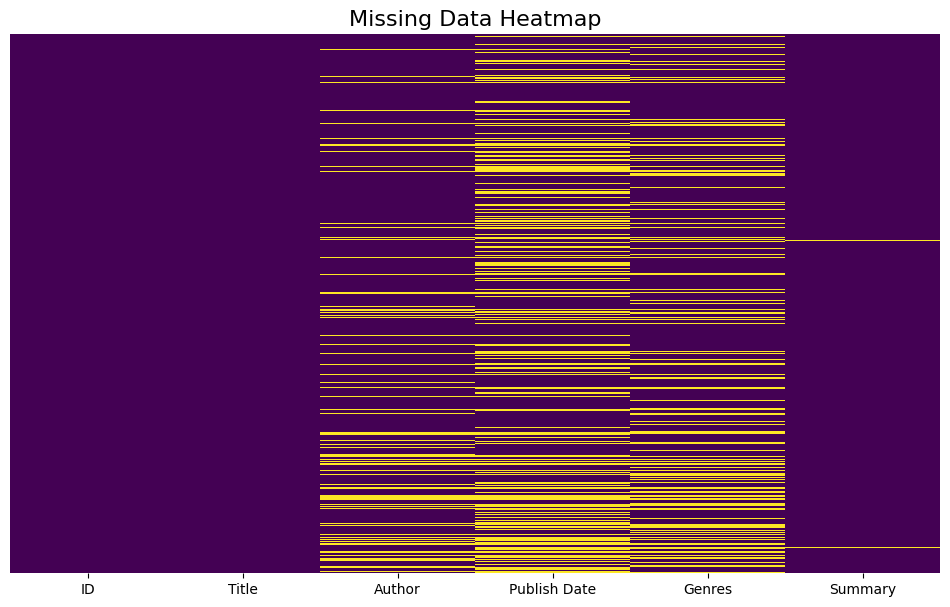

In [ ]:
visualize_missing_data(data)

In [ ]:
data.dropna(subset=['Summary'], inplace=True)
data.count()

ID              16505
Title           16505
Author          14127
Publish Date    10914
Genres          12796
Summary         16505
dtype: int64

### Data Insights

In [ ]:
summary_tokens = data['Summary'].apply(lambda x : len(nltk.word_tokenize(x)))

In [ ]:
def plot_tokens_frequency(bin_width=200, max_x_value=summary_tokens.max()):

    plt.figure(figsize=(10, 6))
    plt.xlabel('Tokens Count')
    plt.ylabel('Frequency')
    plt.title('Distribution of Summary Token Frequency (Bin Width: {})'.format(bin_width))

    num_bins = int(summary_tokens.max() / bin_width)
    print(num_bins)

    counts, bins, patches = plt.hist(summary_tokens, bins=num_bins, edgecolor='black')

    for count, x, patch in zip(counts, bins, patches):
        if x > max_x_value:
            break
        if count > 0:
            plt.text(x + bin_width / 2, count, str(int(count)), ha='center', va='bottom')

    plt.xlim(0, max_x_value)
    plt.show()

58


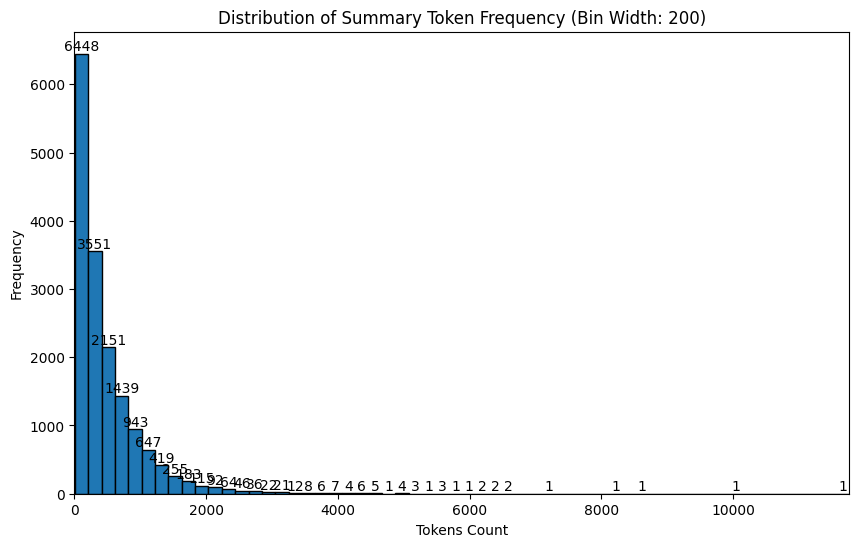

In [ ]:
plot_tokens_frequency()

58


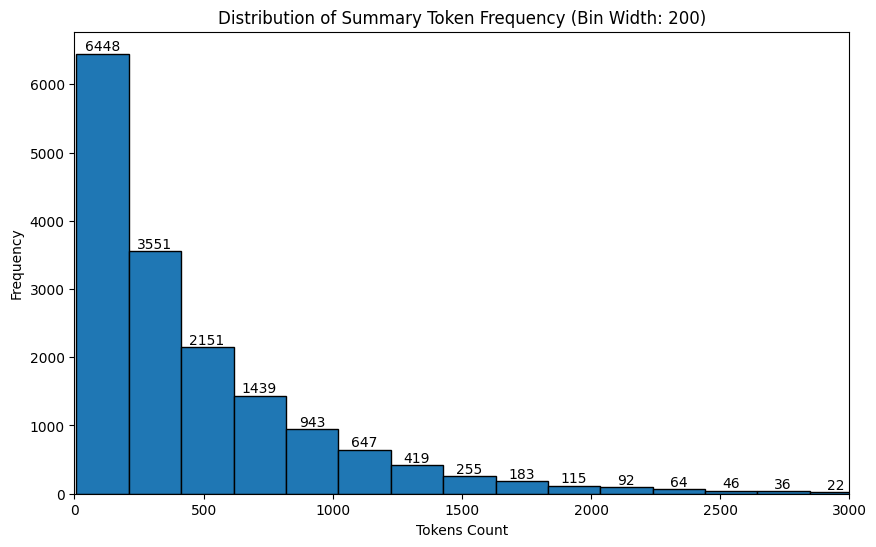

In [ ]:
plot_tokens_frequency(bin_width = 200, max_x_value=3000)

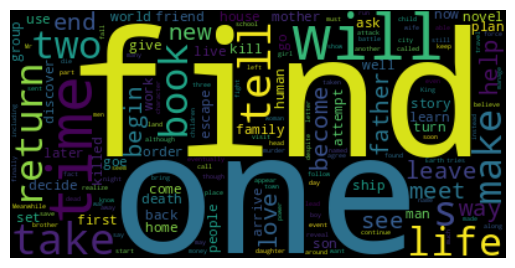

In [ ]:
text = ' '.join(data['Summary'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##4) Summary Condensing (NLP)

Used Model: https://huggingface.co/pszemraj/long-t5-tglobal-base-16384-book-summary

In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/data/'
CSV_FILE = DATA_FOLDER + "cleaned_data.csv"
data = pd.read_csv(CSV_FILE)

### Condensing Summaries

In [ ]:
summarizer = pipeline(
    "summarization",
    "pszemraj/long-t5-tglobal-base-16384-book-summary",
    device=0 if torch.cuda.is_available() else -1,
)

def summarize_text(text):
    tokens_count = len(nltk.word_tokenize(text))
    result = summarizer(text, truncation=True, max_length=min(tokens_count, 77), min_length=min(tokens_count, 25))
    return result[0]['summary_text']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

**Note:** The Vision Model Creator recommends setting parameter 77 to achieve optimal performance.

In [ ]:
condensed_data = data[:20]

with tqdm(total=len(condensed_data)) as pbar:
    def apply_summarization(row):
        summary = summarize_text(row['Summary'])
        pbar.update(1)
        return summary

    condensed_data['Condensed Summary'] = condensed_data.apply(apply_summarization, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1005: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 20/20 [00:39<00:00,  1.68s/it]<ipython-input-8-9bcb5ff29c72>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_data['Condensed Summary'] = condensed_data.apply(apply_summarization, axis=1)
100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


In [ ]:
display(condensed_data[['ID', 'Summary', 'Condensed Summary']])

,ID,Summary,Condensed Summary
0,620,"Old Major, the old boar on the Manor Farm, cal...","The animals on the Farm meet with Major, the b..."
1,843,"Alex, a teenager living in near future England...",Alex is a young English teenager who leads his...
2,986,The text of The Plague is divided into five pa...,The novel opens with a description of Oran in ...
3,1756,The argument of the Enquiry proceeds by a seri...,Hume begins the book by introducing his philos...
4,2080,The novel posits that space around the Milky W...,The novel opens with a description of the five...
5,2152,"The book tells the story of Paul Baumer, a Ger...",The novel opens with Paul Baumer joining the G...
6,2890,"Ged is a young boy on Gont, one of the larger ...",Ged is an orphaned boy on the small island of ...
7,2950,The story is set in an imaginary American town...,The narrator tells us that the town of America...
8,4081,"Living on Mars, Deckard is acting as a consult...","In this chapter, we get a brief look at Deckar..."
9,4082,Beginning several months after the events in B...,"After the events of the previous chapter, Deck..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### Saving Final Dataset

In [ ]:
condensed_data.to_csv(DATA_FOLDER + "final_sample_data.csv", index=False)

##5) Text-to-Image Generation (Vision)

In [ ]:
DATA_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/data/'
CSV_FILE = DATA_FOLDER + "final_sample_data.csv"
condensed_data = pd.read_csv(CSV_FILE)

### 1st Model (More Accurate)

**Used Model:** https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

def generate_image(prompt):
  image = pipe(prompt=prompt).images[0]
  return image

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 2nd Model (CPU Friendly)

**Used Model:** https://huggingface.co/stabilityai/stable-diffusion-2-base

In [ ]:
pipe = diffusers.DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-base")

def generate_image(prompt):
  image = pipe(prompt=prompt).images[0]
  return image

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Generating & Saving Images

In [ ]:
duplicates = condensed_data.duplicated(subset=['Title', 'Author'], keep=False)
print(any(duplicates))

False


In [ ]:
duplicates = condensed_data.duplicated(subset=['ID', 'Title', 'Author'], keep=False)
print(any(duplicates))

False


In [ ]:
IMAGES_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/images/'

condensed_data = condensed_data #[:5] # Change this for generating the whole images

with tqdm(total=len(condensed_data)) as pbar:
  for _, row in condensed_data.iterrows():
      ID = row['ID']
      Title = row['Title']
      Author = row['Author']
      Summary = row['Summary']

      image = generate_image(Summary)

      filename = f'{ID}_{Title}'
      if Author is not pd.NA:
          filename += f'_{Author}'

      filepath = IMAGES_FOLDER + f'{filename}.jpg'
      image.save(filepath)
      pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['farm, renaming it animal farm. they adopt seven commandments of animal ism, the most important of which is, all animals are equal. snowball attempts to teach the animals reading and writing food is plentiful, and the farm runs smoothly. the pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. napoleon takes the pups from the farm dogs and trains them privately. napoleon and snowball struggle for leadership. when snowball announces his plans to build a windmill, napoleon has his dogs chase snowball away and declares himself leader. napoleon enacts changes to the governance structure of the farm, replacing meetings with a committee of pigs, who will run the farm. using a young pig named squealer as a mouthpiece, napoleon claims credit for the windmill idea. the animals work hard

  0%|          | 0/50 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:48<15:23, 48.61s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['their taste for ultra violence. characterized as a sociopath and a hardened juvenile delinquent, alex is also intelligent and quick witted, with sophisticated taste in music, being particularly fond of beethoven, or lovely ludwig van. the novel begins with the droogs sitting in their favorite hangout the korova milkbar, drinking milk drug cocktails, called milk plus, to hype themselves for the night s mayhem. they assault a scholar walking home from the public library, rob a store leaving the owner and his wife bloodied and unconscious, stomp a panhandling derelict, then scuffle with a rival gang. joyriding through the countryside in a stolen car, they break into an isolated cottage and maul the young couple living there, beating the husband and raping his wife. in a metafictional touch, the husband is a writer working on a manuscript ca

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 2/20 [01:35<14:13, 47.42s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the spread of the bubonic plague. the main character, dr. bernard rieux, lives comfortably in an apartment building when strangely the building s concierge, m. michel, a confidante, dies from a fever. dr. rieux consults his colleague, castel, about the illness until they come to the conclusion that a plague is sweeping the town. they both approach fellow doctors and town authorities about their theory, but are eventually dismissed on the basis of one death. however, as more and more deaths quickly ensue, it becomes apparent that there is an epidemic. authorities, including the prefect, m. othon, are slow to accept that the situation is serious and quibble over the appropriate action to take. official notices enacting control measures are posted, but the language used is optimistic and downplays the seriousness of the situation. a special

  0%|          | 0/50 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [02:22<13:26, 47.41s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the philosophy of human nature or, as he calls it, moral philosophy. the latter investigates both actions and thoughts. he emphasizes in this section, by way of warning, that philosophers with nuanced thoughts will likely be cast aside in favor of those whose conclusions more intuitively match popular opinion. however, he insists, precision helps art and craft of all kinds, including the craft of philosophy. next, hume discusses the distinction between impressions and ideas. by impressions, he means sensations, while by ideas, he means memories and imaginings. according to hume, the difference between the two is that ideas are less vivacious than impressions. for example, the idea of the taste of an orange is far inferior to the impression or sensation of actually eating one. writing within the tradition of empiricism, he argues that imp

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 4/20 [03:09<12:36, 47.26s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['equivalent to the real world in behavior and potential. further out, the zone named the beyond can support futuristic technologies such as ai and ftl travel. the outermost zone, the transcend, contains most of the galactic halo and is populated by incomprehensibly vast and powerful posthuman entities. a human expedition investigates a five billion year old data archive that offers the possibility of unimaginable riches for the ambitious young civilization of the straumli realm. the expedition s facility, called high lab, is gradually compromised by a dormant super intelligent entity actually encoded within the archive later known as the blight. the blight rapidly learns how to infiltrate and control the computer systems of high lab, and even develops the ability to possess and control the living humans. the novel starts with an imaginati

  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [03:56<11:48, 47.20s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', nicknamed kat, who becomes paul s mentor. while fighting at the front, baumer and his comrades have to engage in frequent battles and endure the dangerous and often dirty conditions of warfare. at the very beginning of the book erich maria remarque says this book is to be neither an accusation nor a confession, and least of all an adventure, for death is not an adventure to those who stand face to face with it. it will try simply to tell of a generation of men who, even though they may have escaped shells, were destroyed by the war. the book does not focus on heroic stories of bravery, but rather gives a view of the conditions in which the soldiers find themselves. the monotony between battles, the constant threat of artillery fire and bombardments, the struggle to find food, the lack of training of young recruits meaning lower chances

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 6/20 [04:43<11:00, 47.18s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['that he has an extraordinary talent for magic. his aunt, the village witch, teaches him the little she herself knows, but his power far exceeds hers. one day, he uses his talent and a fog gathering spell he learned from a passing weatherworker to save his village from karg raiders. the tale of his remarkable feat spreads far and wide, finally reaching the ear of a wise gontish mage, ogion the silent. he recognizes that the boy is so powerful he must be trained so as not to become a danger to himself and others. in the rite of passage into adulthood, he gives the boy his true name, ged, and takes him as an apprentice. in this world, a magician who knows someone s true name has control over that person, so one s true name is revealed only to those whom one trusts completely. normally, a person is referred to by his or her use name. ged s i

  0%|          | 0/50 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [05:30<10:12, 47.11s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['cronies comptroller schub, treasurer cooley, and police chief magruder. cora appears carried in a litter by her backup singers, and admits that she can accept anything except unpopularity " me and my town ". the scheming comptroller schub, tells her that he has a plan to save her administration, and the town, promising " it s highly unethical." he tells her to meet him at the rock on the edge of town. at the rock, a local mother, mrs. schroeder, tries to tell her child, baby joan, to come down from the rock, when baby joan licks it and a spring of water begins flowing from it. the town instantly proclaims a miracle, and cora and her council eagerly anticipate tourist dollars as they boast of the water s curative powers. miracle song it is soon revealed to cora that the miracle is a fake, controlled by a pump inside the rock. the only per

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 8/20 [06:17<09:25, 47.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [07:05<08:38, 47.11s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and the human template templant for the rachael replicant. she asks deckard to hunt down the missing sixth replicant. at the same time, the human template for roy batty hires dave holden, the blade runner attacked by leon, to help him hunt down the man he believes is the sixth replicant deckard. deckard and holden s investigations lead them to re visit sebastian, bryant, and john isidore from the book do androids dream of electric sheep?, learning more about the nature of the blade runners and the replicants. when deckard, batty, and holden finally clash, batty s inhuman fighting prowess leads holden to believe he has been duped all along and that batty is the sixth replicant he shoots him. deckard returns to sarah with his suspicion there is no sixth replicant. sarah, speaking via a remote camera, confesses that she created and maintain

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 10/20 [07:52<07:51, 47.11s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['commissions joshua to take possession of the land and warns him to keep faith with the covenant. god s speech foreshadows major themes of the book the crossing of the jordan and conquest of the land, its distribution, and the imperative need for obedience to the law joshua s own immediate obedience is seen in his speeches to the israelite commanders and to the transjordanian tribes, and the transjordanians affirmation of joshua s leadership echoes yahweh s assurances of victory. the israelites cross the jordan through the miraculous intervention of god and his ark and are circumcised at gibeath haaraloth translated as hill of foreskins, renamed gilgal in memory gilgal sounds like gallothi, i have removed, but is more likely to translate as circle of standing stones. the conquest begins in canaan with jericho, followed by ai central cana

  0%|          | 0/50 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [08:39<07:03, 47.11s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['documents presented as historical inclusions. chapters 1 6 documents included in the text in italics 1. decree of cyrus, first version cyrus, inspired by god, returns the temple vessels to sheshbazzar, prince of judah, and directs the israelites to return to jerusalem with him and rebuild the temple. 2. 4 2, 3 6 0 exiles, with men servants, women servants and singing men and women, return from babylon to jerusalem and judah under the leadership of zerubbabel and jeshua the high priest. 3. jeshua the high priest and zerubbabel build the altar and celebrate the feast of tabernacles. in the second year the foundations of the temple are laid and the dedication takes place with great rejoicing. 4. letter of the samaritans to artaxerxes, and reply of artaxerxes the enemies of judah and benjamin offer to help with the rebuilding, but are rebuf

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 12/20 [09:26<06:16, 47.07s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['orders a second census. 6 0 1, 7 3 0 men are counted. the tribe of levi is exempted from military service and therefore not included in the census totals. moses consecrates the levites for the service of the tabernacle in the place of the first born sons, who hitherto had performed that service. the levites are divided into three families, the gershonites, the kohathites, and the merarites, each under a chief, and all headed by one prince, eleazar, son of aaron. preparations are then made for resuming the march to the promised land. various ordinances and laws are decreed. the first journey of the israelites after the tabernacle had been constructed is commenced. the people murmur against god and are punished by fire moses complains of the stubbornness of the israelites and is ordered to choose seventy elders to assist him in the govern

  0%|          | 0/50 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [10:13<05:29, 47.09s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sons of naomi then die themselves. naomi decides to return to bethlehem. she tells her daughters in law to return to their own mothers, and remarry. orpah reluctantly leaves however, ruth says, entreat me not to leave you, or to turn back from following you for wherever you go, i will go and wherever you lodge, i will lodge your people shall be my people, and your god, my god. where you die, i will die, and there will i be buried. the lord do so to me, and more also, if anything but death parts you and me. ruth 1 1 6 – 1 7 nkjv the two women return to bethlehem. it is the time of the barley harvest, and in order to support her mother in law and herself, ruth goes to the fields to glean. the field she goes to belongs to a man named boaz, who is kind to her because he has heard of her loyalty to her mother in law. ruth tells her mother in

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 14/20 [11:00<04:42, 47.09s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['a royal decree sent across the empire that men should be the ruler of their households and should speak their own native tongue. ahasuerus then orders all beautiful young girls to be presented to him, so he can choose a new queen to replace vashti. one of these is the orphan esther, whose jewish name is hadassah. after the death of her parents, she is being fostered by her cousin mordecai. she finds favor in the king s eyes, and is made his new queen. esther does not reveal that she is jewish. shortly afterwards, mordechai discovers a plot by courtiers bigthan and teresh to assassinate ahasuerus. the conspirators are apprehended and hanged, and mordechai s service to the king is recorded. ahasuerus appoints haman as his prime minister. mordechai, who sits at the palace gates, falls into haman s disfavor as he refuses to bow down to him.

  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [11:47<03:55, 47.07s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['asks satan his opinion on job. satan answers that job is pious only because god has put a wall around him and blessed his favourite servant with prosperity, but if god were to stretch out his hand and strike everything that job had, then he would surely curse god. god gives satan permission to test job s righteousness. all job s possessions are destroyed 5 0 0 yoke of oxen and 5 0 0 donkeys carried off by sabeans 7, 0 0 0 sheep burned up by the fire of god which fell from the sky 3, 0 0 0 camels stolen by the chaldeans and the house of the firstborn destroyed by a mighty wind, killing job s ten children. still job does not curse god, but instead shaves his head, tears his clothes, and says, naked i came out of my mother s womb, and naked shall i return lord has given, and lord has taken away blessed be the name of lord. as job endures t

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 16/20 [12:34<03:08, 47.03s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['who violates the obligations of marriage to her husband. second, hosea and his wife, gomer, have a son. god commands that the son be named jezreel. this name refers to a valley in which much blood had been shed in israel s history, especially by the kings of the northern kingdom. see i kings 2 1 and ii kings 9 2 1 3 5. the naming of this son was to stand as a prophecy against the reigning house of the northern kingdom, that they would pay for that bloodshed. jezreel s name means god sows. third, the couple have a daughter. god commands that she be named lo ruhamah unloved, or, pity or pitied on to show israel that, although god will still have pity on the southern kingdom, god will no longer have pity on the northern kingdom its destruction is imminent. in the niv translation, the omitting of the word him leads to speculation as to whet

  0%|          | 0/50 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [13:21<02:21, 47.04s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['creature sent by god, swallows jonah. for three days and three nights jonah languishes inside the fish s belly. he says a prayer in which he repents for his disobedience and thanks god for his mercy. god speaks to the fish, which vomits out jonah safely on dry land. after his rescue, jonah obeys the call to prophesy against nineveh, and they repent and god forgives them. jonah is furious, however, and angrily tells god that this is the reason he tried to flee from him, as he knew him to be a just and merciful god. he then beseeches god to kill him, a request which is denied when god causes a tree to grow over him, giving him shade. initially grateful, jonah s anger returns the next day, when god sends a worm to eat the plant, withering it, and he tells god that it would be better if he were dead. god then points out thou hast had pity o

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [14:08<01:33, 46.99s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['judgement against samaria 1 2 – 7 drawing upon ancient traditions for depicting a theophany, the prophet depicts the coming of yahweh to punish the city, whose sins are idolatry and the abuse of the poor. warnings to the cities of judah 1 8 – 1 6 samaria has fallen, judah is next. micah describes the destruction of the lesser towns of judah referring to the invasion of judah by sennacherib, 7 0 1 bc. for these passages of doom on the various cities, the device paronomasia is used. paronomasia is a literary device which plays on the sound of each word for literary effect. for example, the inhabitants of beth le aphrah " house of dust " are told to " roll yourselves in the dust." 1 1 4. though most of the paronomasia is lost in translation, it is the equivalent of\'ashdod shall be but ashes,\' where the fate of the city matches its name. 

  0%|          | 0/50 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [14:55<00:46, 46.98s/it]The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['chosen leader. the language here is not as finely wrought as in some other books of the minor prophets, yet the intent seems straightforward.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['chosen leader. the language here is not as finely wrought as in some other books of the minor prophets, yet the intent seems straightforward.']


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 20/20 [15:42<00:00, 47.11s/it]


### Samples

In [ ]:
IMAGES_FOLDER = '/content/drive/MyDrive/Work/DataCoLab - Technical Task/images/'

def display_images_in_table(max_n=None, n_cols=5):
  html_code = "<table>"
  rows = []

  image_files = [f for f in os.listdir(IMAGES_FOLDER) if os.path.isfile(os.path.join(IMAGES_FOLDER, f))]
  max_n = len(image_files) if max_n == None or max_n >= len(image_files) else max_n

  for i, filename in enumerate(image_files[:max_n]):
    image = Image.open(IMAGES_FOLDER + filename)
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    img_tag = f'<img src="data:image/png;base64,{img_str}" alt="{filename}" width="200">'

    rows.append(f"<td>{img_tag}</td>")

    if (i + 1) % n_cols == 0:
      html_code += f"<tr>{''.join(rows)}</tr>"
      rows = []

  if rows:
    html_code += f"<tr>{''.join(rows)}</tr>"

  html_code += "</table>"
  display(HTML(html_code))

**5 Samples Corresponding to the First 5 Records:**

#### 1st Model

In [ ]:
display_images_in_table(max_n=15)

Output hidden; open in https://colab.research.google.com to view.

#### 2nd Model

In [ ]:
display_images_in_table()

Output hidden; open in https://colab.research.google.com to view.